In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
import math
import yfinance as yf



In [17]:
def error_function(real_Value,predicted_Value):
    #mse
    sse=((real_Value- predicted_Value)**2)
    mean_squared_error= np.mean(sse)
    #mse=np.mean((actual - prediction) ** 2)
    #print("\n"+str(type)+" MSE error: {:.4f}".format(mse))
    
    #rmse
    root_mean_squared_error=np.sqrt(mean_squared_error)
    """print(str(type)+" RMSE error: {:.4f}".format(rmse))
    y_test_predict=regressor.predict(X_test)
    mse = sklearn.metrics.mean_squared_error(actual, prediction)
    print("\n"+"Training mean squared error: {:.5f}".format(mean_squared_error))
    rmse = math.sqrt(mean_squared_error)
    print("RMSE error: {:.4f}".format(rmse))
    #rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
    r2t = r2_score(actual, prediction)
    #print(rmse)
    print(r2t)"""
    return mean_squared_error,root_mean_squared_error



In [24]:
# plotting of graphs
def plot_graphs(real_value, training_data, test_data):
    plt.plot(real_value, label="The actual value", color="red")
    plt.plot(training_data, label="Prediction on training data", color='blue')
    test_data = [j for j in test_data]
    # connect train and test lines
    test_data.insert(0, training_data[-1])
    # x values for test prediction plot
    plt.plot([x for x in range(len(training_data) - 1, len(training_data) + len(test_data) - 1)], test_data, label="Prediction on testing data", color='green')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Stock price Prediction")
    plt.legend()
    plt.grid()
    plt.show()

In [4]:
class LSTM:

    def __init__(self, input=2, lstm_cell_weights=2, output=1, learning_rate=0.5):
        # set number of nodes in each input, hidden, output layer
        self.input_nodes = input
        self.lstm_cell_weights = lstm_cell_weights
        self.output_nodes = output

        # fw = weights for forget gate
        self.fw = np.random.randn(self.input_nodes, self.lstm_cell_weights).T
        # iw = weights for input gate
        self.iw = np.random.randn(self.input_nodes, self.lstm_cell_weights).T
        # ow = weights for ouput gate
        self.ow = np.random.randn(self.input_nodes, self.lstm_cell_weights).T
        # cw = weights for candidate
        self.cw = np.random.randn(self.input_nodes, self.lstm_cell_weights).T
        # low = weights from LSTM cells to output
        self.low = np.random.randn(2, 1).T

        # set default LSTM cell state
        self.cell_state = [[1, 1] for i in range(100)]
        self.cell_state = np.array(self.cell_state, dtype=float)
        self.cell_state = np.array(self.cell_state, ndmin=2).T

        # learning rate
        self.learn = learning_rate

    # sigmoid activation function
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    # tanh activation function
    def tanh(self, x):
        return 1 - np.square(np.tanh(x))

    def forget_gate(self, gate_input, out=1):
        gate_input = np.dot(self.fw, gate_input)
        gate_input = out * gate_input
        gate_output = self.sigmoid(gate_input)
        self.cell_state = self.cell_state * gate_output

    def input_gate(self, gate_input, out=1):
        gate_input_1 = np.dot(self.iw, gate_input)
        gate_input_1 = out * gate_input_1
        gate_input_2 = np.dot(self.cw, gate_input)
        gate_input_2 = out * gate_input_2
        gate_output = self.sigmoid(gate_input_1) * self.tanh(gate_input_2)
        self.cell_state = self.cell_state + gate_output

    def output_gate(self, gate_input, out=1):
        gate_input = np.dot(self.ow, gate_input)
        gate_input = out * gate_input
        gate_output = self.sigmoid(gate_input)
        out = self.tanh(self.cell_state) * gate_output

        return out

    def forward(self, input_1, input_2, input_3):
        self.cell_state = [[1, 1] for i in range(len(input_1[0]))]
        self.cell_state = np.array(self.cell_state, dtype=float)
        self.cell_state = np.array(self.cell_state, ndmin=2).T
        # Pass input though first lstm cell
        self.forget_gate(input_1)
        self.input_gate(input_1)
        fin_out = self.output_gate(input_1)
        # Pass input though second lstm cell
        self.forget_gate(input_2, fin_out)
        self.input_gate(input_2, fin_out)
        fin_out = self.output_gate(input_2, fin_out)
        # Pass input though third lstm cell
        self.forget_gate(input_3, fin_out)
        self.input_gate(input_3, fin_out)
        fin_out = self.output_gate(input_3, fin_out)
        # dot product of final cell output and output weights
        final_input = np.dot(self.low, fin_out)
        # compute the neural networks output
        final_output = self.sigmoid(final_input)
        return final_output, fin_out

    def error(self, target, final_output):
        output_error = target - final_output
        hidden_error = np.dot(self.low.T, output_error)

        return output_error, hidden_error

    def backpropagation(self, train_x1, train_x2, train_x3, fin_out, final_output, output_error,
                        cell_error):
        self.low += self.learn * np.dot((output_error * final_output * (1.0 - final_output)), fin_out.T)
        self.fw += self.learn * np.dot((cell_error * fin_out * (1.0 - fin_out)), train_x1.T)
        self.iw += self.learn * np.dot((cell_error * fin_out * (1.0 - fin_out)), train_x2.T)
        self.cw += self.learn * np.dot((cell_error * fin_out * (1.0 - fin_out)), train_x2.T)
        self.ow += self.learn * np.dot((cell_error * fin_out * (1.0 - fin_out)), train_x3.T)

    def train(self, train_x1, train_x2, train_x3, target):
        # convert lists to 2d arrays
        train_x1 = np.array(train_x1, ndmin=2).T
        train_x2 = np.array(train_x2, ndmin=2).T
        train_x3 = np.array(train_x3, ndmin=2).T
        target = np.array(target, ndmin=2).T

        # forward propagation 
        final_output, fin_out = self.forward(train_x1, train_x2, train_x3)

        # calculate output and cell output error
        output_error, cell_error = self.error(target, final_output)

        # back propagation
        self.backpropagation(train_x1, train_x2, train_x3, fin_out, final_output, output_error,
                             cell_error)

        return final_output

    def test(self, test_x1, test_x2, test_x3):
        # transpose input
        test_x1 = test_x1.T
        test_x2 = test_x2.T
        test_x3 = test_x3.T
        # forward propagation
        final_output, fin_out = self.forward(test_x1, test_x2, test_x3)
        # return final input
        return final_output

[*********************100%***********************]  1 of 1 completed
training cycle:0
training cycle:1
training cycle:2
training cycle:3
training cycle:4
training cycle:5
training cycle:6
training cycle:7
training cycle:8
training cycle:9
training cycle:10
training cycle:11
training cycle:12
training cycle:13
training cycle:14
training cycle:15
training cycle:16
training cycle:17
training cycle:18
training cycle:19
training cycle:20
training cycle:21
training cycle:22
training cycle:23
training cycle:24
training cycle:25
training cycle:26
training cycle:27
training cycle:28
training cycle:29
training cycle:30
training cycle:31
training cycle:32
training cycle:33
training cycle:34
training cycle:35
training cycle:36
training cycle:37
training cycle:38
training cycle:39
training cycle:40
training cycle:41
training cycle:42
training cycle:43
training cycle:44
training cycle:45
training cycle:46
training cycle:47
training cycle:48
training cycle:49
training cycle:50
training cycle:51
train

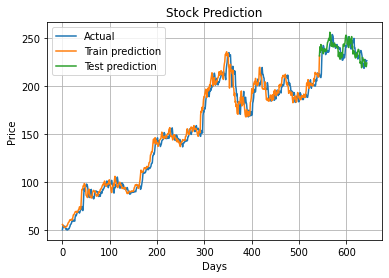

In [25]:
def main():
    # read into dataframe
    #url="https://raw.githubusercontent.com/bmounikareddy98/Machine-learning-project/main/sbi.csv"
    #df = pd.read_csv(url)
    #extract only the adjusted close prices of the selected stock
    df = yf.download('GOOG','1998-11-01','2021-11-01')
    
    df = df['Adj Close']
    normalization_value=1000
    #1st two days
    train_x1 = [[df[i-6], df[i-5]] for i in range(len(df[:550])) if i >= 6]
    #3rd and 4th day
    train_x2 = [[df[i-4], df[i-3]] for i in range(len(df[:550])) if i >= 6]
    #5th and 6th day
    train_x3 = [[df[i-2], df[i-1]] for i in range(len(df[:550])) if i >= 6]
    #7th day or targeted train_pred
    train_y = [[i] for i in df[6:550]]
    
    #convert into arrays
    train_x1 = np.array(train_x1, dtype=float)
    train_x2 = np.array(train_x2, dtype=float)
    train_x3 = np.array(train_x3, dtype=float)
    train_y = np.array(train_y, dtype=float)

    # Normalize
    train_x1= train_x1/normalization_value
    train_x2 = train_x2/normalization_value
    train_x3 = train_x3/normalization_value
    train_y = train_y/normalization_value

    # create neural networks
    NN = LSTM()

    # number of training cycles
    training_cycles = 100
    # train the neural network
    for cycle in range(training_cycles):
        print("training cycle:"+str(cycle))
        for n in train_x1:
            train_pred = NN.train(train_x1, train_x2, train_x3, train_y)

    # print various accuracies
    
    error_mse_train, error_rmse_train=error_function(train_y,train_pred)
    print("Mean squared error of train data: "+ str(error_mse_train))
    print("Root mean squared error of train data: "+ str(error_rmse_train))
    # de-Normalize
    train_pred = np.array(train_pred, dtype=float)
    train_pred *=normalization_value
    train_y *=normalization_value
    
    # transpose
    train_pred = train_pred.T




    test_x1 = [[df[i - 6], df[i - 5]] for i in range(550, 650)]
    test_x2 = [[df[i - 4], df[i - 3]] for i in range(550, 650)]
    test_x3 = [[df[i - 2], df[i - 1]] for i in range(550, 650)]
    test_y = [[i] for i in df[550:650]]

    test_x1 = np.array(test_x1, dtype=float)
    test_x2 = np.array(test_x2, dtype=float)
    test_x3 = np.array(test_x3, dtype=float)
    test_y = np.array(test_y, dtype=float)


    # Normalize

    test_x1 = test_x1/normalization_value
    test_x2 = test_x2/normalization_value
    test_x3 = test_x3/normalization_value
    test_y = test_y/normalization_value

    # test_pred the network with unseen data
    test_pred = NN.test(test_x1, test_x2, test_x3)
    test_pred = np.array(test_pred, dtype=float)

    # print various accuracies
    error_mse_test, error_rmse_test=error_function(test_y, test_pred)
    print("Mean squared error of test data: "+ str(error_mse_test))
    print("Root mean squared error of test data: "+ str(error_rmse_test))

    # de-Normalize data
    test_pred *=normalization_value

    test_y *=normalization_value


    # transplose test_pred results
    test_pred = test_pred.T



    # plotting training and test_pred results on same graph
    
    #print(df.head())
    df = df.to_frame()
    #print(df['Adj Close'].values)
    
    plot(df['Adj Close'].values[0:644], train_pred, test_pred)


if __name__ == '__main__':
    main()

In [14]:
error_mse_test, error_rmse_test=errors(test_y, test_pred)
print("Mean squared error of test data: "+ error_mse_test)
print("Root mean squared error of test data: "+ error_rmse_test)
error_mse_train, error_rmse_train=error_function(train_y,train_pred)
print("Mean squared error of test data: "+ error_mse_train)
print("Root mean squared error of test data: "+ error_rmse_train)


NameError: ignored

[*********************100%***********************]  1 of 1 completed


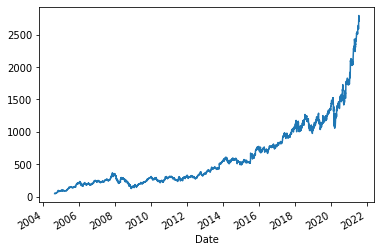

In [88]:

# Get the data for the stock AAPL
data = yf.download('GOOG','1998-01-01','2021-08-01')

# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the close price of the AAPL
data['Adj Close'].plot()
plt.show()

In [7]:
pip install yfinance

     |████████████████████████████████| 6.3 MB 30.8 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
